In [23]:
import os
import sys

import pandas as pd
import numpy as np

from sklearn.preprocessing import normalize, scale
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from collections import OrderedDict

from synchromesh.scripts.utils import read_str_list, sanitize_mtx, norm, do_pf, do_log_pf
from synchromesh.scripts.plot import  plot_depth_norm, plot_depth_dist, plot_knee, plot_pc_depth, plot_mean_var, plot_monotone, plot_example_gene

from scipy.sparse import csr_matrix
from scipy.io import mmread, mmwrite
from scipy import stats


import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.gridspec import GridSpec
import matplotlib.gridspec as gridspec

def nd(arr):
    return np.asarray(arr).reshape(-1)

def yex(ax):
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    
    # now plot both limits against eachother
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    return ax

fsize=15


alpha = 0.33

import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams["font.size"] = fsize
%config InlineBackend.figure_format = 'retina'

In [2]:
cividis = matplotlib.cm.get_cmap("cividis")
colors = {
    "cell": cividis(0.01),
    "gene": cividis(0.5),
    "mono": cividis(0.99)
}

In [29]:
def get_min_diff(matrix):
    x = matrix.flatten()
    xs = np.sort(x)
    b = xs[0]
    mn = 1100.
    for i in range(1, xs.shape[0]):
        a = xs[i]
        if a == b:
            continue

        diff = abs(a-b)
        if diff < mn and diff > 0:
            mn = diff
        b = a
    return mn

def mono(matrix, raw):
    rv = np.zeros(matrix.shape[0])
    for i in range(matrix.shape[0]):
        r, p  = stats.spearmanr(matrix[i], raw[i])
        rv[i] = r
    return rv

def plot_meanvar(mtx, raw_mean, minlim = 1e-4, maxlim = 1e5, ax=None):
    p = {
        "xlabel": "Gene mean",
        "ylabel": "Gene variance",
        "xscale": "log",
        "yscale": "log",
        "xlim": (minlim, maxlim),
    }
    
    gvar = np.var(mtx, axis=0)
    gcov = np.sqrt(np.var(gvar))/np.mean(gvar)

    y = np.var(mtx, axis=0)
    yy = (y-y.mean())/np.sqrt(np.var(y))

    ax.scatter(raw_mean, y, facecolor=colors["gene"], alpha=alpha, edgecolor="k", label=f"CoV: {gcov:,.1f}")
    ax.legend(prop={"size": 12})
    ax.set(**p)
    yex(ax)
    return ax

def plot_depth(mtx, raw_cell_counts, ax):
    x = raw_cell_counts
    y = np.sum(mtx, axis=1)
    
    minx, maxx = min(x), max(x)
    miny, maxy = min(y), max(y)
    maxy = maxy - miny

    xx = (x - minx)/maxx
    yy = (y - miny)/maxy
    
    close = np.all(np.allclose(y, y[0]))
    if close:
        yy = [1]*len(y)
    ax.scatter(xx,yy, edgecolor="k", facecolor=colors["cell"], alpha=alpha)
        
    reg = LinearRegression().fit(xx.reshape(-1,1), yy)
    r2 = reg.score(xx.reshape(-1,1), yy)

    if close:
        # handle the degenerate case where the slope is 0 since all values y are same
        r2 = 0
    
    xxx = np.array([min(xx), max(xx)])

    ax.plot(xxx, reg.coef_*xxx+ reg.intercept_, color="darkgray", linestyle="--", label=f"r$^2$: {r2:,.2f}", linewidth=3)
    

    p = {
      "xlabel": "Raw cell count",
      "ylabel": "Transform cell count",
      "xlim": (-0.1, 1.1),
      "ylim": (-0.1, 1.1),
    }
    ax.set(**p)
    ax.legend(prop={"size": 12})
    return ax

def plot_mono(matrix, raw, ax):
    x = mono(matrix, raw)
    p = {
        "xlabel": "Spearman r",
        "ylabel": "Frequency",
        "xlim": (-0.1, 1.2)
    }
    close = np.all(np.allclose(x, x[0]))
    if close:
        weights=np.ones(len(x)) / len(x)
        x = np.array([1] * len(x))
        ax.hist(x, facecolor=colors["mono"], edgecolor="k", weights=weights)
    else:
        weights=np.ones(len(x)) / len(x)
        ax.hist(x, facecolor=colors["mono"], weights=weights, edgecolor="k")
    ax.axvline(x.mean(), linestyle="--", color="darkgray", label=f"mean: {x.mean():,.2f}")
    ax.set(**p)
    ax.legend(prop={"size": 12})
    return ax

In [9]:
def read_data(base_data_fn):
    data = {}

    for title in read_labels:
        print(f"loading {title}")
        in_fn = os.path.join(base_data_fn, f"{title}.mtx.gz")
        data[title] = mmread(in_fn).toarray()

    title = "sctransform"
    print(f"loading {title}")
    in_fn = os.path.join(base_data_fn, f"{title}.csv")
    data[title] = pd.read_csv(in_fn, header=None).values

    title = "cp10k_log_scale"
#     print(f"loading {title}")
#     in_fn = os.path.join(base_data_fn, f"{title}.csv")
#     data[title] = pd.read_csv(in_fn, header=None).values
    data[title] = scale(data["cp10k_log"])
    return data

In [10]:
read_labels = ['raw', 'pf', 'log', 'pf_log', 'pf_log_pf', 'cpm_log', 'cp10k_log', "sqrt"]
labels = ['raw', 'pf', "sqrt", 'log', 'cp10k_log', 'cpm_log', 'cp10k_log_scale', 'sctransform', 'pf_log', 'pf_log_pf']

In [18]:
ds = "GSM3711784"
out_prefix =  os.path.join("synchromesh/data/", ds)

In [19]:
%%time
data = read_data(out_prefix)

loading raw
loading pf
loading log
loading pf_log
loading pf_log_pf
loading cpm_log
loading cp10k_log
loading sqrt
loading sctransform
CPU times: user 1min 16s, sys: 1.74 s, total: 1min 17s
Wall time: 1min 18s


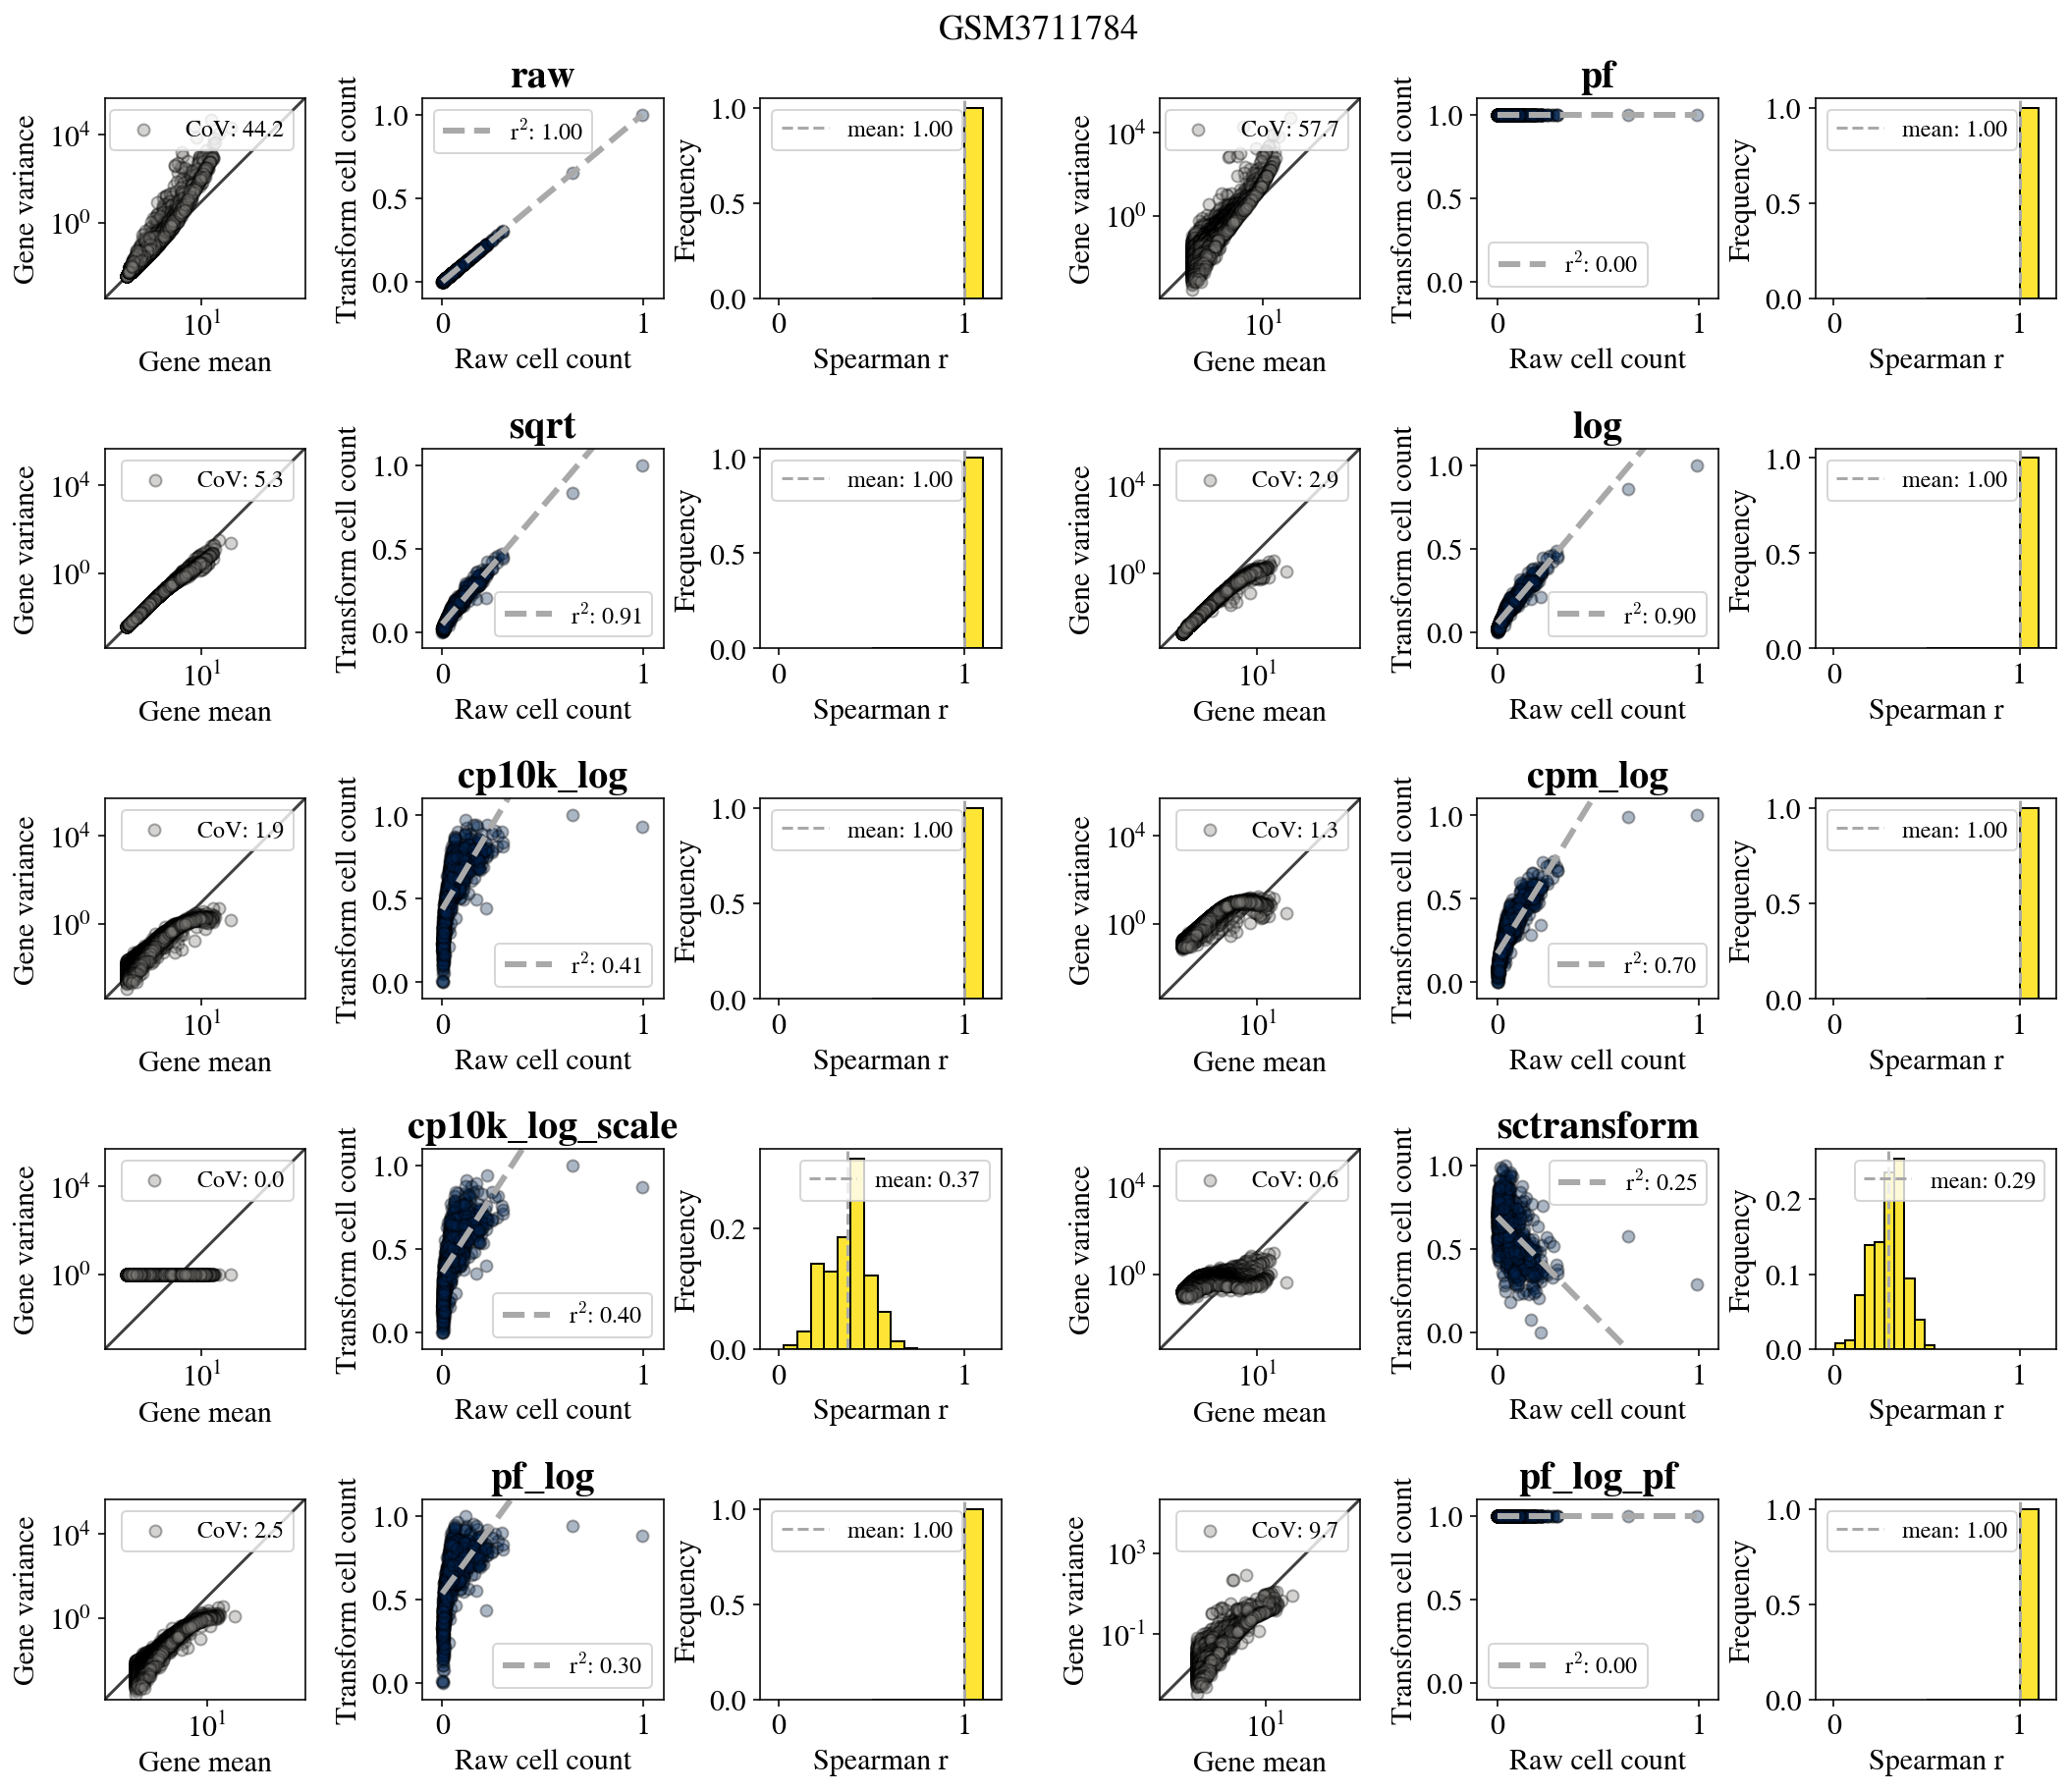

In [30]:
fig = plt.figure(figsize=(6*3,5*3))
fig.suptitle(ds, y=0.92)
gs = gridspec.GridSpec(5, 2, figure=fig, wspace=0.15, hspace=0.75)
axs = []
for i in range(5):
    for j in range(2):
        ig = gs[i,j].subgridspec(1, 3, wspace=0.4)
        ax1 = fig.add_subplot(ig[0, 0])
        ax2 = fig.add_subplot(ig[0, 1])
        ax3 = fig.add_subplot(ig[0, 2])
        axs.append((ax1, ax2, ax3))

raw = data["raw"]

minlim = min(np.min(np.var(raw, 0)), np.min(np.mean(raw, 0))) * 0.1
maxlim = max(np.max(np.var(raw, 0)), np.max(np.mean(raw, 0))) * 10
for (ax1, ax2, ax3), title in zip(axs, labels):
    m = data[title]
    plot_meanvar(m, raw.mean(0), minlim = minlim, maxlim = maxlim, ax=ax1)
    plot_depth(m, raw.sum(1), ax2)
    plot_mono(m, raw, ax3)
    ax2.set_title(title, fontsize=20, weight="bold")

#fig.savefig(f"{ds}_methods_metrics.png", facecolor='white', transparent=False, dpi=300, bbox_inches="tight")
fig.show()

In [ ]:
# depth scatter